In [90]:
import os
from PIL import Image
import numpy as np
from typing import Callable, List, Dict
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, balanced_accuracy_score, mean_squared_error

In [91]:
gt_dir = "./data/training/groundtruth"
pred_dir = "out/experiment_name_2023_03_21__22_18_10/run/data/training/images"
image_dir = "./data/training/images"

threshold = 0.5  # threshold for binary images

In [92]:
# assuming images are in the same order
assert os.listdir(gt_dir) == os.listdir(pred_dir), \
    "prediction and groundtruth directories have a different structure"

image_names = np.array(os.listdir(gt_dir))

def name_from_index(i: int):
    return image_names[i]

def index_from_name(name: str):
    return np.where(image_names == name)[0][0]

images = np.array([np.array(Image.open(os.path.join(image_dir, fname))) for fname in image_names])
gt_images = np.array([np.array(Image.open(os.path.join(gt_dir, fname))) for fname in image_names])
pred_images = np.array([np.array(Image.open(os.path.join(pred_dir, fname))) for fname in image_names])

gt_images_bool = (gt_images / 255) > threshold
pred_images_bool = (pred_images / 255) > threshold

In [93]:
def compute_metric(stat_func: Callable, y_true: np.array, y_pred: np.array):
    res = np.zeros(gt_images.shape[0], dtype=float)
    for i in range(gt_images.shape[0]):
        score = stat_func(y_true=y_true[i].ravel(), y_pred=y_pred[i].ravel())
        res[i] = score

    return res

In [94]:
# threshold prediction (values between 0 and 1, relevant for boxplot)
threshold_metrics = {
    "Jaccard": compute_metric(jaccard_score, gt_images_bool, pred_images_bool),
    "F1": compute_metric(f1_score, gt_images_bool, pred_images_bool),
    "Bal. Acc.": compute_metric(balanced_accuracy_score, gt_images_bool, pred_images_bool),
}

# raw prediction
raw_metrics = {
    "MSE": compute_metric(mean_squared_error, gt_images / 255, pred_images / 255),
}

In [95]:
def compute_statistics(items: List[Dict], should_plot=True):
    """
    :param items: list of dictionaries
    :param should_plot: If boxplot should be plotted (will always plot in Jupyter).
    :return: List of dictionaries with name of metric, statistics, and values
    """

    bp_data = plt.boxplot(list(items.values()), labels=list(items.keys()))
    metric_stats = []
    for i, (metric, values) in enumerate(items.items()):
        stats = {
            "lower_whisker": bp_data["whiskers"][i * 2].get_ydata()[1],
            "lower_quartile": bp_data["boxes"][i].get_ydata()[1],
            "median": bp_data["medians"][i].get_ydata()[1],
            "upper_quartile": bp_data["boxes"][i].get_ydata()[2],
            "upper_whisker": bp_data["whiskers"][(i * 2) + 1].get_ydata()[1],
            "mean": values.mean(),
            "min": values.min(),
            "max": values.max(),
            "best": name_from_index(np.argmax(values)),
            "worst": name_from_index(np.argmin(values))
        }
        stats["bad_outlier_indices"] = np.where(values < stats["lower_whisker"])[0]
        stats["bad_outlier_images"] = name_from_index(stats["bad_outlier_indices"])

        stats["good_outlier_indices"] = np.where(values > stats["upper_whisker"])[0]
        stats["good_outlier_images"] = name_from_index(stats["good_outlier_indices"])

        metric_stats.append({
            "metric": metric,
            "stats": stats,
            "values": values
        })

    if should_plot:
        for i, metric_stat in enumerate(metric_stats):
            outliers = np.concatenate(
                (metric_stat["stats"]["bad_outlier_indices"], metric_stat["stats"]["good_outlier_indices"])
            )
            for outlier_index in outliers:
                # 0.08 cause of overlaps
                plt.annotate(name_from_index(outlier_index), xy=(1+i+0.08, metric_stat["values"][outlier_index]))
        plt.plot()

    return metric_stats

# Boxplots

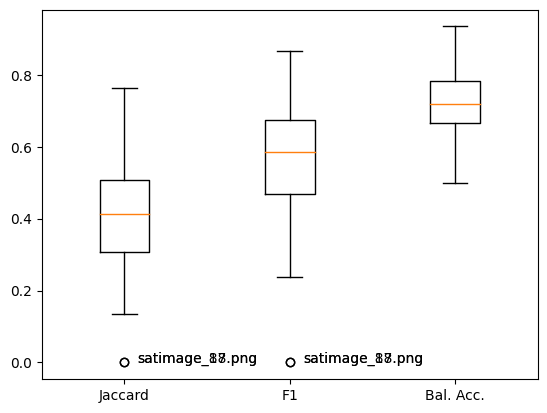

In [120]:
# current run has two outliers at 0 for both Jaccard and F1
# if annotations overlap, outliers can also be seen in the printed statistics
threshold_stats = compute_statistics(items=threshold_metrics)

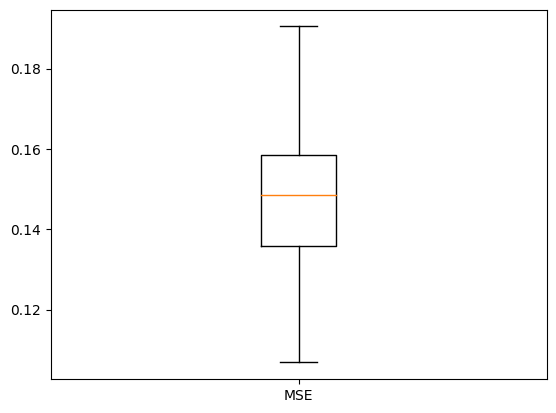

In [97]:
raw_stats = compute_statistics(items=raw_metrics)

In [98]:
def print_stats(metric_stats):
    for metric_stat in metric_stats:
        print(metric_stat["metric"])
        stat_names = metric_stat["stats"].keys()
        longest_name = len(max(stat_names, key=len))
        print("-" * longest_name)
        for stat_name, stat_value in metric_stat["stats"].items():
            formatted_value = stat_value
            if isinstance(stat_value, float):
                formatted_value = f"{stat_value:.4f}"
            print(f"{stat_name.ljust(longest_name)} {formatted_value}")
        print()

# Statistics

In [99]:
print_stats(threshold_stats)
print_stats(raw_stats)

Jaccard
--------------------
lower_whisker        0.1353
lower_quartile       0.3060
median               0.4132
upper_quartile       0.5075
upper_whisker        0.7626
mean                 0.4104
min                  0.0000
max                  0.7626
best                 satimage_122.png
worst                satimage_17.png
bad_outlier_indices  [ 80 104]
bad_outlier_images   ['satimage_17.png' 'satimage_88.png']
good_outlier_indices []
good_outlier_images  []

F1
--------------------
lower_whisker        0.2383
lower_quartile       0.4686
median               0.5847
upper_quartile       0.6733
upper_whisker        0.8653
mean                 0.5644
min                  0.0000
max                  0.8653
best                 satimage_122.png
worst                satimage_17.png
bad_outlier_indices  [ 80 104]
bad_outlier_images   ['satimage_17.png' 'satimage_88.png']
good_outlier_indices []
good_outlier_images  []

Bal. Acc.
--------------------
lower_whisker        0.5000
lower_quarti

In [117]:
def overlay_mask(image: np.array, mask: np.array, clear_gb_channels=True):
    # add mask to image
    image = image.copy().astype(np.float32)
    image[...,0] = np.minimum(255, image[...,0] + mask)  # set red channel to 255

    if clear_gb_channels:
        image[...,1][mask == 255] = 0  # set green channel to zero
        image[...,2][mask == 255] = 0  # set blue channel to zero

    return image.astype(np.uint8)

def highlight_prediction(i):
    gt = Image.fromarray(gt_images[i])
    pred = Image.fromarray(pred_images[i])
    pred_bool = ((pred_images[i] / 255) > threshold) * 255

    img = Image.fromarray(images[i]).convert("RGB")  # remove transparency
    img_gt_overlay = overlay_mask(np.asarray(img), gt_images[i])
    img_pred_overlay = overlay_mask(np.asarray(img), pred_images[i])
    img_pred_bool_overlay = overlay_mask(np.asarray(img), pred_bool)

    fig, axarr = plt.subplot_mosaic("ABC;DEF;GHI", width_ratios=[1,1,0.6])
    fig.set_size_inches(7, 8)
    # Ground Truth
    axarr["A"].imshow(gt, cmap="gray")
    axarr["B"].imshow(img_gt_overlay)
    axarr["A"].set_title("Ground Truth")

    # Raw Prediction
    axarr["D"].imshow(pred, cmap="gray")
    axarr["E"].imshow(img_pred_overlay)
    axarr["D"].set_title("Raw Prediction")

    # Threshold Prediction
    axarr["G"].imshow(pred_bool, cmap="gray")
    axarr["H"].imshow(img_pred_bool_overlay)
    axarr["G"].set_title(f"Threshold Prediction ({threshold})")


    [axis[1].set_axis_off() for axis in list(axarr.items())]
    table_options = {"loc": "center", "colWidths": [0.4, 0.6]}

    # Ground Truth Table
    table_c = axarr["C"].table([
        ["Image", name_from_index(i)],
        ["Index", i]
    ], **table_options)
    table_c.scale(1.5, 1.5)

    # Raw Prediction Table
    table_f = axarr["F"].table([
        [m["metric"], f"{m['values'][i]:.4f}"] for m in raw_stats
    ], **table_options)
    table_f.scale(1.5, 1.5)

    # Threshold Prediction Table
    table_i = axarr["I"].table([
        [m["metric"], f"{m['values'][i]:.4f}"] for m in threshold_stats
    ], **table_options)
    table_i.scale(1.5, 1.5)

    fig.tight_layout()

# Images of Outliers

### Best Performance

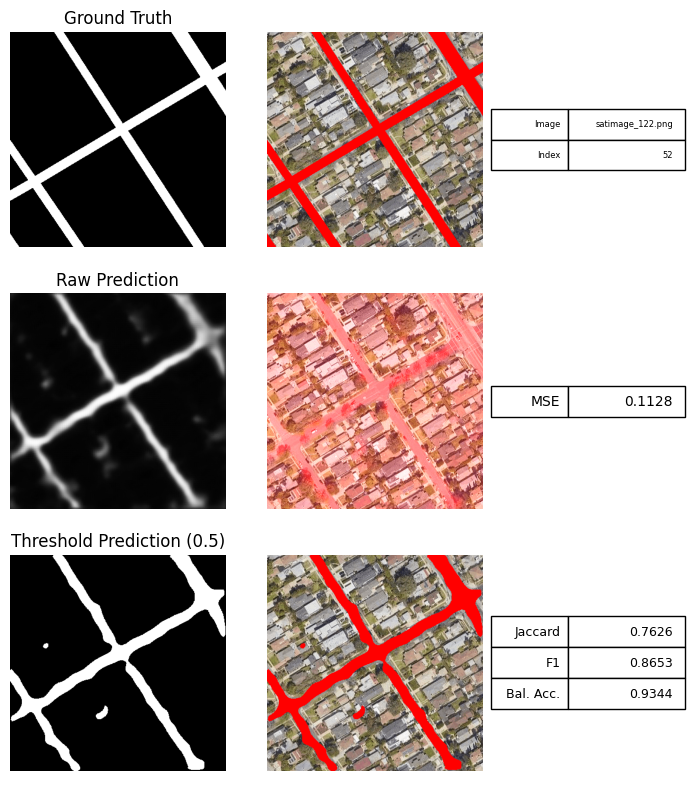

In [118]:
# Compare all outlier images for Jaccard score
assert threshold_stats[0]["metric"] == "Jaccard"
best_image = threshold_stats[0]["stats"]["best"]
highlight_prediction(i=index_from_name(best_image))

### Worst Performance

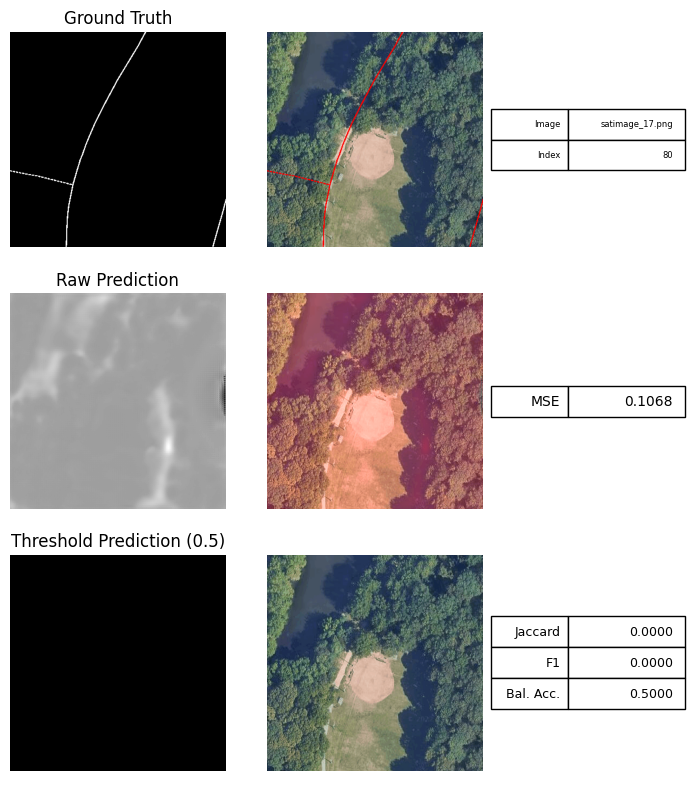

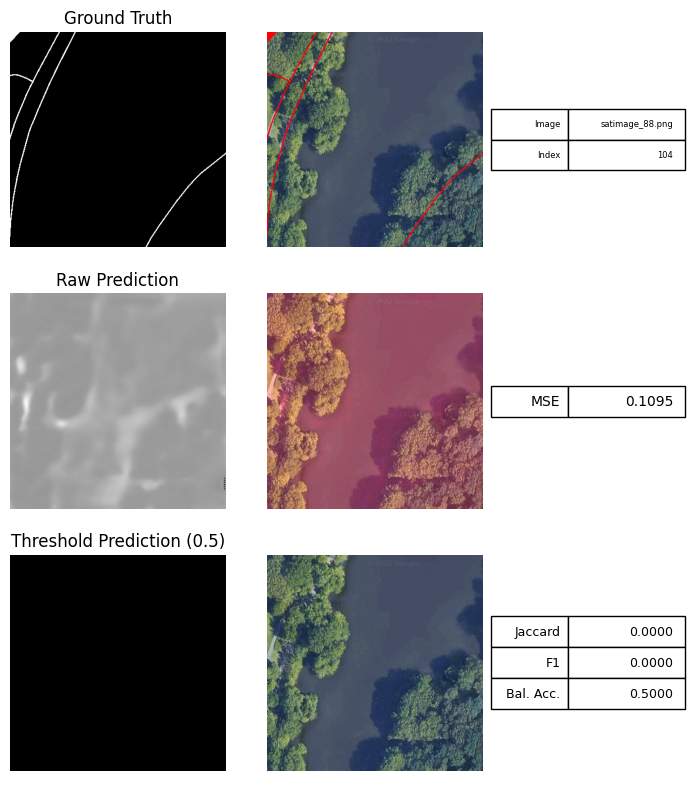

In [119]:
# Compare all outlier images for Jaccard score
assert threshold_stats[0]["metric"] == "Jaccard"
outlier_indices = threshold_stats[0]["stats"]["bad_outlier_indices"]
for oi in outlier_indices:
    highlight_prediction(oi)